In [ ]:
# Importing Libraries
import os 
import time
import pickle
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# NLTK Libraries
import re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu

# Pytorch Libraries
import torch
import numpy as np
import pandas as pd
import torchvision
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
from matplotlib import pyplot as plt
from torch.utils.data import random_split

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Loading the available device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
import matplotlib.pyplot as plt
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [ ]:
# Encoder : Encode the Images from [BS,3,224,224] to [BS,196,512]
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()

  def modelLoad(self):
    model = models.vgg16(pretrained="True", progress="True")
    modules = list(model.features.children())[:-2]    #Take model after removing FCs and last maxpool & RELU to get feature maps of dim 512
    self.model_ft = nn.Sequential(*modules)
    self.model_ft = self.model_ft.to(device)
    self.model_ft.eval()

  def encoding(self, images):
    images_features = self.model_ft(images)
    images_features = images_features.permute(0, 2, 3, 1)
    images_features = images_features.view(images_features.shape[0],-1,images_features.shape[-1])    #Reshape
    return images_features # BS X 196 X 512

In [ ]:
class FlickrDataset(Dataset):
    """
    FlickrDataset
    """
    def __init__(self,root_dir, caption_file, transform=None, freq_threshold=5):
        # Initialization
        self.root_dir = root_dir
        self.df = pd.read_csv(caption_file)
        self.freq_threshold = freq_threshold
        self.transform = transforms.Compose([
                                transforms.Resize(226),
                                transforms.RandomCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ])
        
        #Get image and caption colum from the dataframe
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]
        
        #Initialize vocabulary and build vocab

        # vocab_dict maintains the count of each token
        self.vocab_dict = {"<PAD>":1, "<start>":1, "<end>":1, "<UNK>":1}

        # vocab_list maintains the index for each token
        self.vocab_list = {"<PAD>":0, "<start>":1, "<end>":2, "<UNK>":3}

        # Reverse Indexing
        self.reverse_vocab_list = {0:"<PAD>", 1:"<start>", 2:"<end>", 3:"<UNK>"}
        
        self.caption_vector = []
        self.modified_caption = []
        self.caption_to_vector(self.captions)   
        
    def __len__(self):
      return len(self.df) 
    
    def caption_to_vector(self, captions):
      self.max_len = 0

      for value in captions:
        value = value.lower()
        tokens = word_tokenize(value)
        count = 0
        for j in range(len(tokens)):
          if (tokens[j].isalpha() == True):
            count += 1

            # Maintain the count of each token in vocab_dict
            if tokens[j] not in self.vocab_dict:
              self.vocab_dict[tokens[j]] = 0
            self.vocab_dict[tokens[j]] += 1

        # Maximum number of tokens in any caption
        if(count > self.max_len):
          self.max_len = count
      # Increment the max length by 2, one for <start> & another for <end> keyword.
      self.max_len += 2

      index = 4
      for value in captions:
        value = value.lower()
        tokens = word_tokenize(value)

        # Staring with start keyword, represented by 1 in numeric
        temp = [1]
        for j in range(0, len(tokens)):
          if (tokens[j].isalpha() == True):
            if self.vocab_dict[tokens[j]] >= self.freq_threshold:
              if tokens[j] not in self.vocab_list:

                # First occurance of word
                self.vocab_list[tokens[j]] = index
                self.reverse_vocab_list[index] = tokens[j]
                temp.append(index)
                index += 1
              else:
                temp.append(self.vocab_list[tokens[j]])
            else:
              # If word is occuring less than Threshold, then insert <UNK> keyword
              temp.append(self.vocab_list["<UNK>"])
        temp.append(self.vocab_list["<end>"])

        # Padding the <PAD> keyword to maintain the length equals to max_len
        for i in range(len(temp), self.max_len):
          temp.append(self.vocab_list["<PAD>"])
        self.caption_vector.append(temp)
        
    
    def __getitem__(self,idx):
        caption = self.captions[idx]
        caption_vector = self.caption_vector[idx]
        modified_caption = self.modified_caption[idx]
        img_name = self.imgs[idx]
        img_location = self.root_dir+"/"+img_name
        img = Image.open(img_location).convert("RGB")
        
        #apply the transfromation to the image
        if self.transform is not None:
            img = self.transform(img)
        
        
        #return img, caption, modified_caption, caption_vector
        return torch.tensor(caption_vector), img

In [ ]:
# Complete dataset, consist of all images & its corresponding caption vectors
dataset = FlickrDataset('/content/drive/MyDrive/Shared DL Project Folder/flikr8k/Images', '/content/drive/MyDrive/Shared DL Project Folder/flikr8k/captions.txt')

In [ ]:
caption_vector, image_feature = dataset[1000]

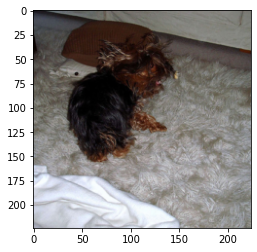

In [ ]:
show_image(image_feature)

In [ ]:
print(image_feature.shape,"\n", caption_vector)

torch.Size([3, 224, 224]) 
 tensor([   1,    4,   27,   29,   40,   28,    9,   88,   37,    4,   39,  957,
        1048,    2,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0])


In [ ]:
# val_size = len(dataset) * 0.01
val_size = 640
train_size = len(dataset) - val_size
print(train_size, val_size)

# Splitting the dataset into train & validation dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

print(len(train_dataset), len(val_dataset))

39815 640
39815 640


In [ ]:
print(train_dataset[500][0].shape)
print(train_dataset[500][1].shape)

torch.Size([36])
torch.Size([3, 224, 224])


In [ ]:
# DataLoader
from torch.utils.data.dataloader import DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size, drop_last=True)

In [ ]:
# Batch dimensions
for xb, yb in train_loader:
  print(xb.shape, yb.shape)
  break

torch.Size([64, 36]) torch.Size([64, 3, 224, 224])


In [ ]:
# Attention Module
class Attention(nn.Module):
  def __init__(self, attention_dimension, hidden_dimension, image_dimension):
    super(Attention, self).__init__()
    self.hidden_dimension = hidden_dimension
    self.attention_dimension = attention_dimension
    self.image_dimension = image_dimension
    self.W = nn.Linear(self.hidden_dimension, self.attention_dimension)
    self.U = nn.Linear(self.image_dimension, self.attention_dimension)
    self.A = nn.Linear(self.attention_dimension, 1)
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax(dim=1)

  def forward(self, image_out, hidden_out):
    u_attn = self.U(image_out) # bs X 196 X attention_dimension
    w_attn = self.W(hidden_out) # bs X attention_dimension
    out = self.relu(u_attn+w_attn.unsqueeze(dim=1)) # bs X 196 X attention_dimension
    e = self.A(out) # bs X 196 X 1
    e = e.squeeze(2) # bs X 196
    a = self.softmax(e) # bs X 196
    c = (image_out * a.unsqueeze(2)).sum(dim=1) # bs X 196 X 512
    # c = torch.sum(mul_out, dim=1)
    return c


In [ ]:
# Sample output test for attention module
attention = Attention(256, 2048, 512)
image = torch.rand(32, 196, 512)
hidden = torch.rand(32, 2048)
attn = attention.forward(image, hidden)
print(attn.shape)

torch.Size([32, 512])


In [ ]:
class Decoder(nn.Module):
  def __init__(self, hidden_dimension, embed_size, vocab_size, image_dimension, attention_dimension, batch_size, max_len):
    super(Decoder, self).__init__()
    self.hidden_dimension = hidden_dimension
    self.embed_size = embed_size
    self.vocab_size = vocab_size
    self.image_dimension = image_dimension
    self.batch_size = batch_size
    self.max_len = max_len

    self.word_embeddings = nn.Embedding(self.vocab_size, self.embed_size)
    self.lstm = nn.LSTMCell(self.image_dimension+self.embed_size, self.hidden_dimension, bias=True)
    self.init_h = nn.Linear(self.image_dimension, self.hidden_dimension)
    self.init_c = nn.Linear(self.image_dimension, self.hidden_dimension)
    self.attention = Attention(attention_dimension, hidden_dimension, image_dimension)
    self.linear = nn.Linear(self.hidden_dimension, self.vocab_size)
    self.f_beta = nn.Linear(self.hidden_dimension, self.image_dimension)
    self.sigmoid = nn.Sigmoid()
    self.dropout = nn.Dropout(0.3)
    self.init_weights()

  def init_weights(self):
        """
        Initializes some parameters with values from the uniform distribution, for easier convergence.
        """
        self.word_embeddings.weight.data.uniform_(-0.1, 0.1)
        self.linear.bias.data.fill_(0)
        self.linear.weight.data.uniform_(-0.1, 0.1)

  def forward(self, image_feature, caption_feature):
    embedding = self.word_embeddings(caption_feature) # bs X max_len X embed_size
    mean_image_feature = torch.mean(image_feature, dim=1) # bs X image_dimension
    h = self.init_h(mean_image_feature) # bs X hidden_dimension
    c = self.init_c(mean_image_feature) # bs X hidden_dimension

    pred_out = torch.zeros(self.batch_size, self.max_len-1, self.vocab_size).to(device)
    
    for i in range(0, self.max_len-1):
      attention_out = self.attention.forward(image_feature, h) # bs X image_dimension
      f_beta_out = self.sigmoid(self.f_beta(h)) # bs X image_dimension
      attention_weighted_encoding = f_beta_out * attention_out # bs X image_dimension
      concat_out = torch.cat((embedding[:,i], attention_weighted_encoding), dim=1) # bs X (embed_size+image_dimesion)
      h, c = self.lstm(concat_out, (h, c)) # 1 X bs X hidden_dimesion
      out = self.linear(self.dropout(h)) # 1 X bs X vocab_size
      pred_out[:,i] = out
      
    return pred_out

  def predict(self, single_image_feature):
    sentence = ["<start>"]
    start_tensor = torch.tensor([1])
    
    mean_image_feature = torch.mean(single_image_feature, dim=1) # 1 X image_dimension
    h = self.init_h(mean_image_feature) # 1 X hidden_dimension
    c = self.init_c(mean_image_feature) # 1 X hidden_dimension
    
    for i in range(0, self.max_len):
      start_tensor = start_tensor.to(device) # Based on start word (start_tensor) & attention output, we'll try to find next word

      embedding = self.word_embeddings(start_tensor) # 1 x 512
      attention_out = self.attention.forward(single_image_feature, h) # 1 X image_dimension
      f_beta_out = self.sigmoid(self.f_beta(h)) # 1 X image_dimension
      attention_weighted_encoding = f_beta_out * attention_out # 1 X image_dimension
      concat_out = torch.cat((embedding, attention_weighted_encoding), dim=1) # 1 X (embed_size+image_dimesion)
      
      h, c = self.lstm(concat_out, (h, c)) # 1 X hidden_dimesion
      out = self.linear(self.dropout(h)) # 1 X vocab_size
      predicted_word = out.view(-1) # vocab_size
      index = torch.argmax(predicted_word).item() # Index of maximum value in "predicted_word"
      next_word = dataset.reverse_vocab_list[index] # Getting the word for that index
      sentence.append(next_word) # Appending the word to sentence
      start_tensor = torch.tensor([index]) # Assign the index to start tensor
      if next_word == "<end>":
        break
    return sentence



In [ ]:
# Setting up the hyper parameters
hidden_dimension = 1024
embed_size = 300
image_dimension = 512
attention_dimension = 256

In [ ]:
import torch.nn.functional as F
from tqdm.notebook import tqdm
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dimension,image_dimension,hidden_dimension,drop_prob=0.3):
        super().__init__()
        self.encoder = Encoder()
        self.encoder.modelLoad()
        self.decoder = Decoder(hidden_dimension,
                               embed_size,
                               vocab_size,
                               image_dimension,
                               attention_dimension,
                               batch_size,
                               dataset.max_len)
        
    def forward(self, images, captions):
        # Encoder : Encoding of Image
        features = self.encoder.encoding(images)
        # Decoder : Takes encoded image & caption, and return final output (caption)
        outputs = self.decoder(features, captions)
        return outputs


In [ ]:
# Model instance
model = EncoderDecoder(
    embed_size=embed_size,
    vocab_size = len(dataset.vocab_list),
    attention_dimension=attention_dimension,
    image_dimension=image_dimension,
    hidden_dimension=hidden_dimension
).to(device)

# Loss
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab_list["<PAD>"])

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [1]:
Training of model

num_epochs = 25
print_every = 100

for epoch in range(3,num_epochs+1):   
    for idx, (captions, image) in enumerate(iter(train_loader)):

        # Load image & caption to current device
        image,captions = image.to(device),captions.to(device)
      
        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs = model(image, captions)

        # Calculate the batch loss.
        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, len(dataset.vocab_list)), targets.reshape(-1))
        
        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()

        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
            
            
            
            model.eval()
            with torch.no_grad():
                dataiter = iter(val_loader)
                _, img = next(dataiter)
                print(img.shape, img[0:1].shape, img[0].shape)

                # Generate the caption for the fisrt Image from first validation batch 
                features = model.encoder.encoding(img[0:1].to(device))
                caps = model.decoder.predict(features)
                caption = ' '.join(caps)
                show_image(img[0],title=caption)
                
            model.train()

    #  Saving the trained model till the the time
    torch.save(model.state_dict(), '/content/drive/MyDrive/Shared DL Project Folder/chirag/epoch'+str(epoch))

In [ ]:
model1 = EncoderDecoder(embed_size=embed_size,
    vocab_size = len(dataset.vocab_list),
    attention_dimension=attention_dimension,
    image_dimension=image_dimension,
    hidden_dimension=hidden_dimension).to(device)

# Loading the final pretrained model
model1.load_state_dict(torch.load('/content/drive/MyDrive/Shared DL Project Folder/chirag/epoch25'))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


<All keys matched successfully>

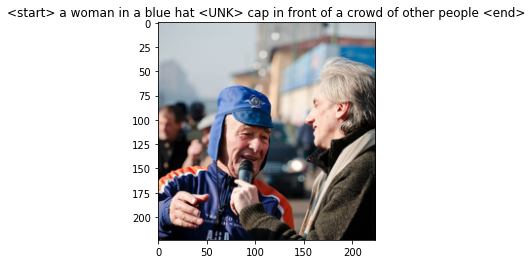

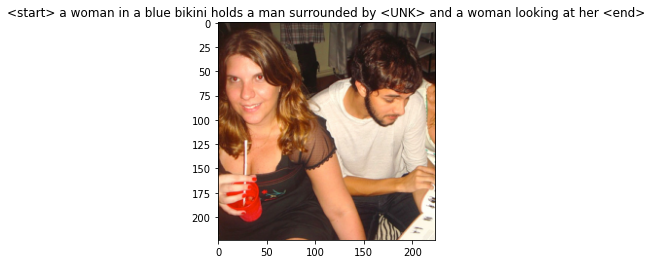

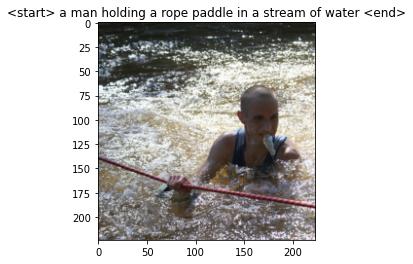

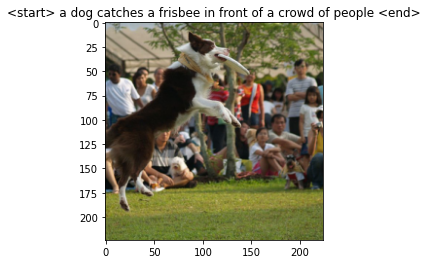

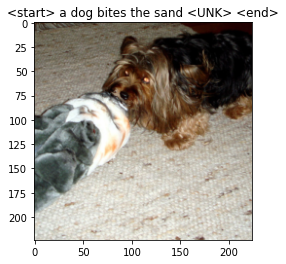

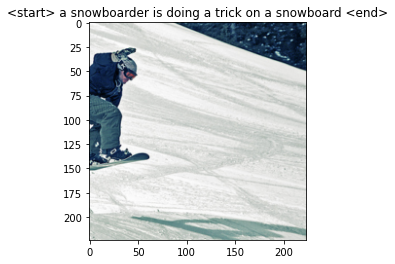

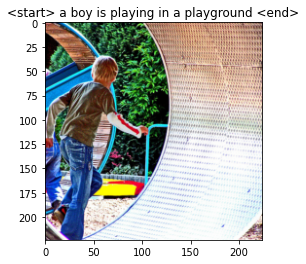

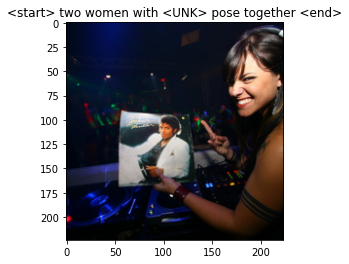

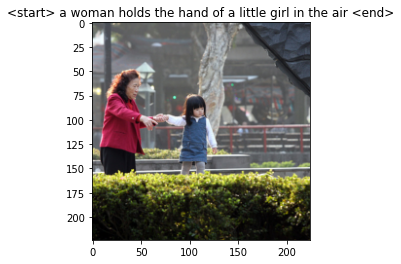

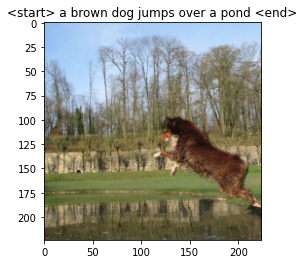

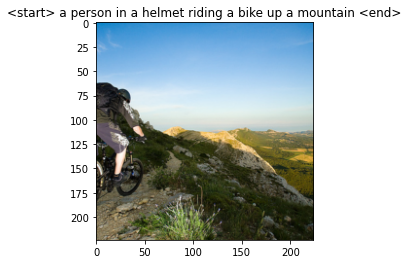

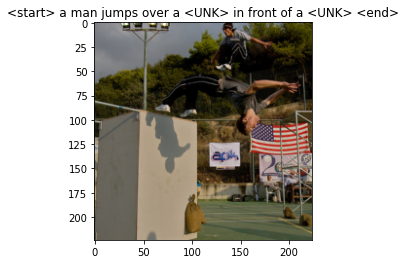

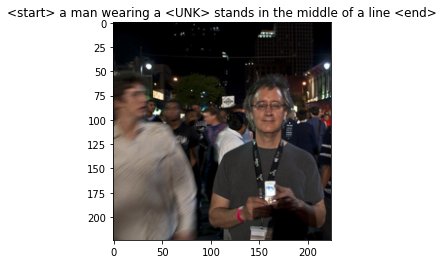

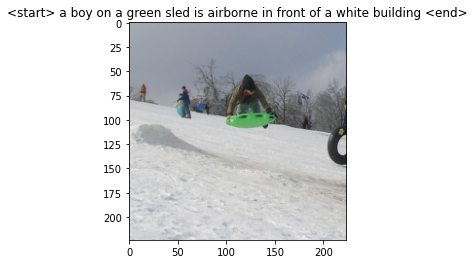

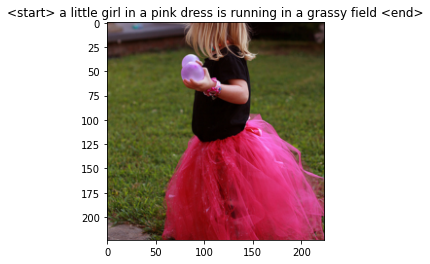

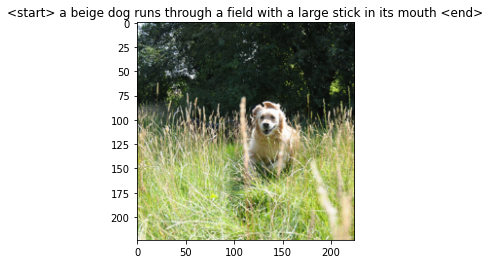

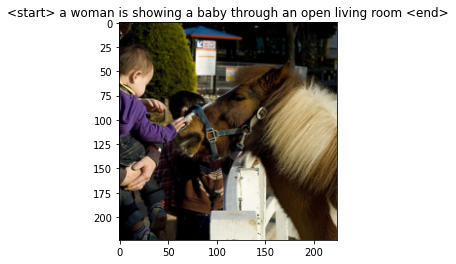

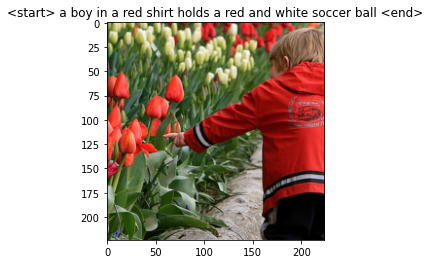

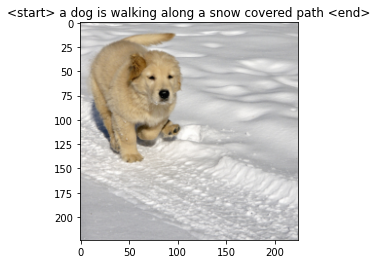

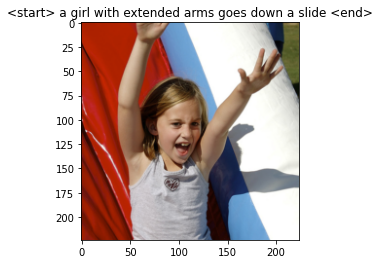

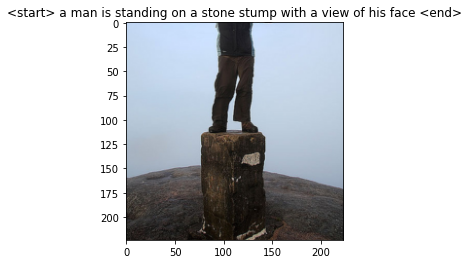

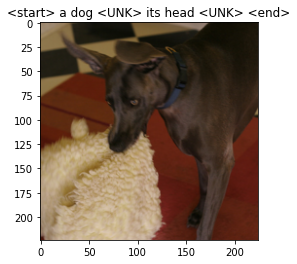

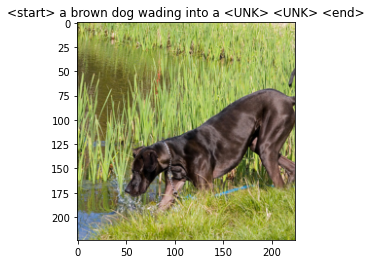

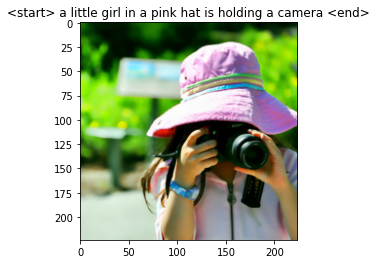

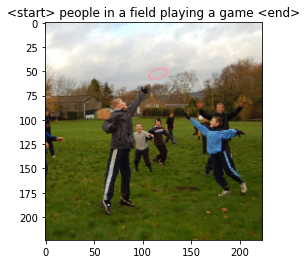

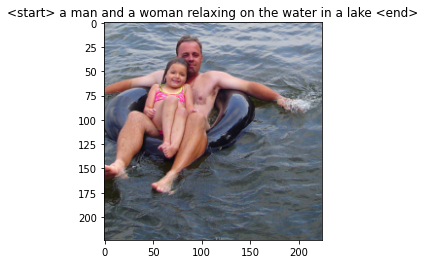

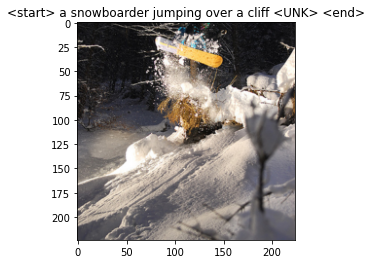

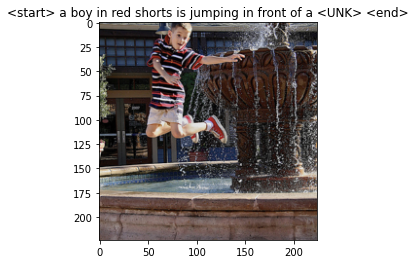

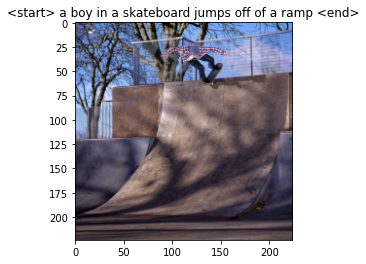

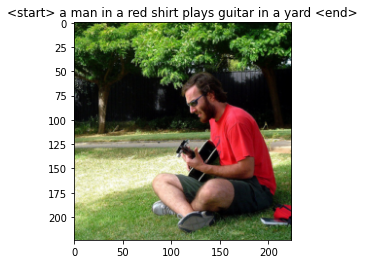

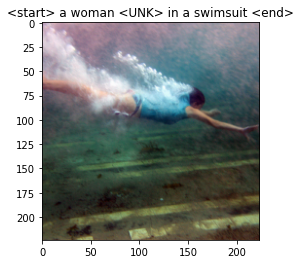

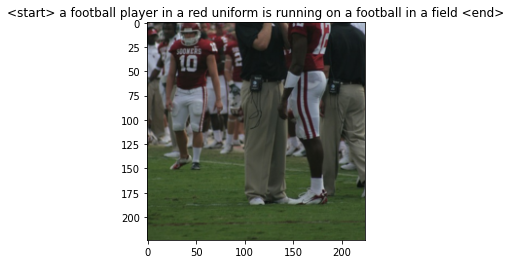

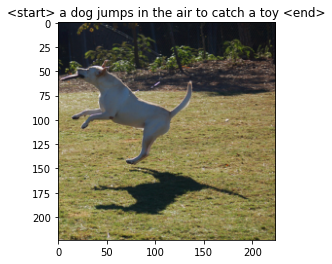

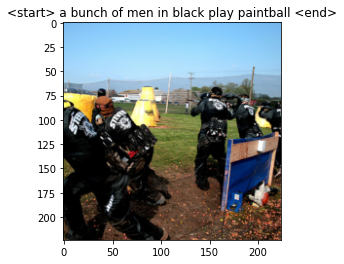

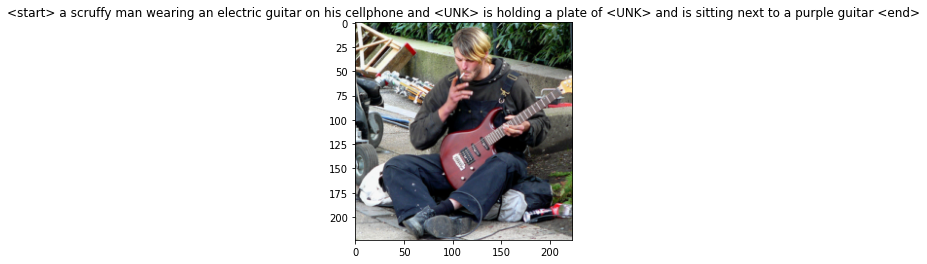

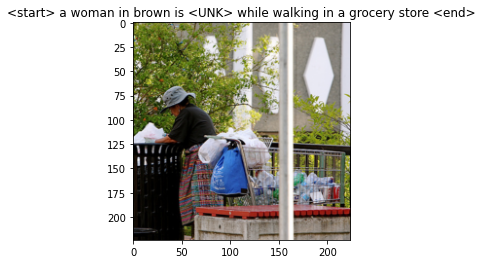

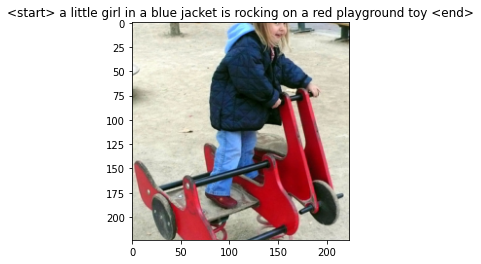

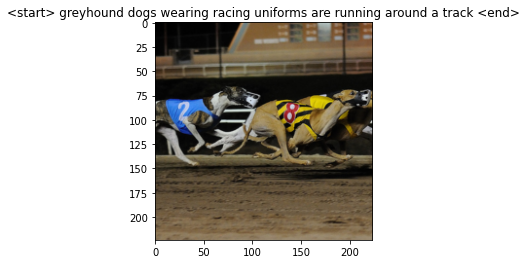

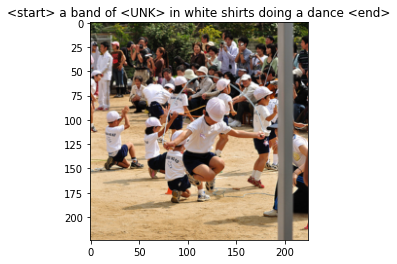

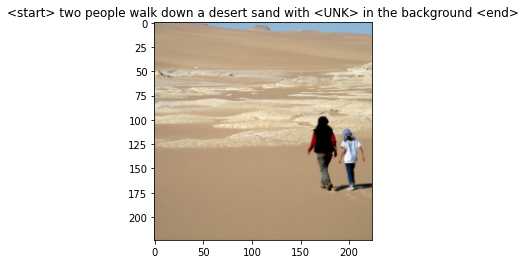

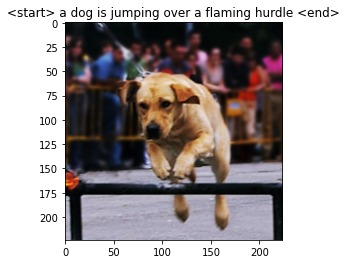

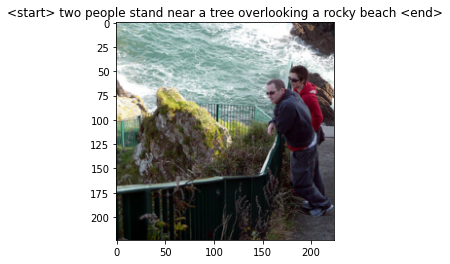

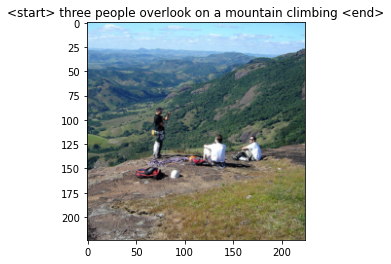

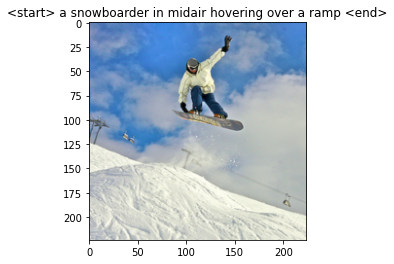

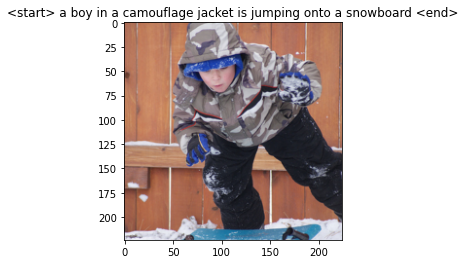

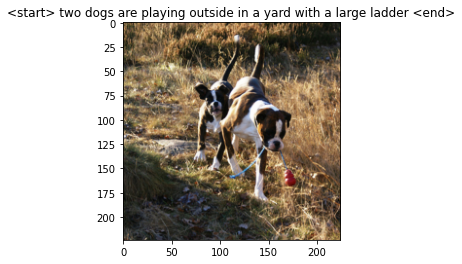

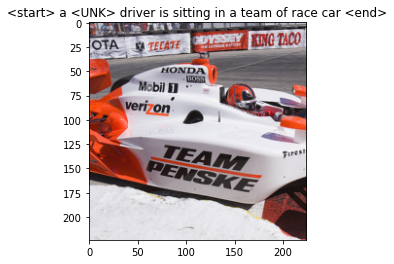

In [ ]:
dataiter = iter(val_loader)
# Iterating for each batch
for idx, (captions, image) in enumerate(iter(val_loader)):
  # Iterating for each image in corresponding batch
  for i in range(0, image.size(0)):
    features = model1.encoder.encoding(image[i].unsqueeze(0).to(device))
    # Generating the caption for corresponding image
    caps = model1.decoder.predict(features)
    caption = ' '.join(caps)
    show_image(image[i],title=caption)
  break